In [ ]:
from sklearn import datasets
from sklearn.decomposition import PCA
from keras.datasets import mnist
import numpy as np

In [ ]:
def clustering_objective(data, centroids):
    total_sum = float(0)

    for point in data:
        total_sum += min([np.dot(point - centroid, point - centroid) for centroid in centroids])

    return total_sum / float(len(data))

In [ ]:
def get_euclidean_distance(p1, p2):
    difference = p1 - p2
    sum_of_squared_diff = np.dot(difference, difference)
    distance = np.sqrt(sum_of_squared_diff)
    return distance

In [ ]:
def davies_bouldin_index(data, cluster_affiliation, centroids):
    k = len(np.unique(cluster_affiliation))
    max_radius = np.zeros(k)
    for i in range(k):
        cluster_points = data[cluster_affiliation == i]
        centroid = centroids[i]
        distances = np.array([get_euclidean_distance(point, centroid) for point in cluster_points])
        max_radius[i] = np.max(distances)

    db_index = 0.0
    for i in range(k):
        max_val = float('-inf')
        for j in range(k):
            if i != j:
                val = (max_radius[i] + max_radius[j]) / get_euclidean_distance(centroids[i], centroids[j])
                if val > max_val:
                    max_val = val
        db_index += max_val

    return db_index / k

In [ ]:
def dunn_index(data, cluster_affiliation, centroids):
    k = len(np.unique(cluster_affiliation))
    min_inter_cluster_distance = float('inf')
    max_intra_cluster_diameter = float('-inf')

    for i in range(k):
        cluster_points = data[cluster_affiliation == i]
        centroid = centroids[i]
        intra_cluster_distances = np.array([get_euclidean_distance(point, centroid) for point in cluster_points])
        max_intra_cluster_diameter = max(max_intra_cluster_diameter, np.max(intra_cluster_distances))

        for j in range(k):
            if i != j:
                inter_cluster_distance = get_euclidean_distance(centroids[i], centroids[j])
                min_inter_cluster_distance = min(min_inter_cluster_distance, inter_cluster_distance)

    return min_inter_cluster_distance / max_intra_cluster_diameter


In [ ]:
def purity_score(true_labels, cluster_affiliation):
    contingency_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(cluster_affiliation))))
    for i, true_label in enumerate(np.unique(true_labels)):
        true_mask = (true_labels == true_label)
        for j, cluster_label in enumerate(np.unique(cluster_affiliation)):
            cluster_mask = (cluster_affiliation == cluster_label)
            contingency_matrix[i, j] = np.sum(true_mask & cluster_mask)

    purity = np.sum(np.max(contingency_matrix, axis=0)) / len(true_labels)
    return purity

In [ ]:
def rand_index(true_labels, cluster_affiliation):
    a = 0
    b = 0
    n = min(len(true_labels), len(cluster_affiliation))

    for i in range(n):
        for j in range(i + 1, n):
            same_true_cluster = (true_labels[i] == true_labels[j])
            same_pred_cluster = (cluster_affiliation[i] == cluster_affiliation[j])

            if same_true_cluster and same_pred_cluster:
                a += 1
            elif not same_true_cluster and not same_pred_cluster:
                b += 1

    rand_idx = (a + b) / (n * (n - 1) / 2)
    return rand_idx


In [ ]:
from sklearn import datasets
from sklearn.decomposition import PCA
from keras.datasets import mnist
import numpy as np

def initialize_centroids(data, k):
    centroids_indices = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[centroids_indices, :]
    return centroids



def kmeans(data, k):
    N = np.size(data, 0)

    # Centroids initialization
    centroids = initialize_centroids(data, k)

    # Cluster affiliation: [cluster_number, cluster_number, ..., ..., ..., ...]
    cluster_affiliation = np.array([-1 for _ in range(0, N)])

    flag = 1  # Initialize flag
    j_prev = float('inf')

    while flag:
        # Assign each data point to the closest centroid
        for i, point in enumerate(data):
            min_distance = float('inf')
            min_distance_index = None

            # Find the closest centroid for each data point
            for cluster_index, centroid in enumerate(centroids):
                distance = get_euclidean_distance(centroid, point)
                if distance < min_distance:
                    min_distance = distance
                    min_distance_index = cluster_index

            # Record or update cluster for each data point
            if cluster_affiliation[i] != min_distance_index:
                cluster_affiliation[i] = min_distance_index

        # Recompute centroids
        for cluster_index in range(k):
            # Extract data points belonging to the current cluster
            grouped_points = data[cluster_affiliation == cluster_index]

            # Check if there are data points in the cluster
            if len(grouped_points) > 0:
                # Calculate the sum using dot product along axis 0
                sum_grouped_points = np.sum(grouped_points, axis=0)

                # Calculate the mean and update the centroid
                centroids[cluster_index] = sum_grouped_points / len(grouped_points)

        # Calculate the clustering objective
        j = clustering_objective(data, centroids)

        # Terminate the loop based on the termination criteria
        if abs(j - j_prev) <= 1e-5 * j:
            flag = False
        j_prev = j

    return centroids, cluster_affiliation

# Load MNIST dataset using Keras
(train_images, train_labels), (_, _) = mnist.load_data()

# Reshape and normalize the images
train_images = train_images.reshape((60000, 28 * 28)).astype('float32') / 255.0

no_of_clusters = 10
no_of_training_data = 5000

# Choose a subset of training data for clustering
subset_digits = train_images[:no_of_training_data]

print(f"Number of clusters = {no_of_clusters}")
print(f"Length of train set = {len(subset_digits)}")

normalized_centroids, cluster_affiliation = kmeans(subset_digits, no_of_clusters)
centroids = normalized_centroids * 255
print(np.unique(cluster_affiliation))


Number of clusters = 10
Length of train set = 5000
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
true_labels = train_labels[:no_of_training_data]
internal_objective = clustering_objective(subset_digits, normalized_centroids)
davies_bouldin = davies_bouldin_index(subset_digits, cluster_affiliation, normalized_centroids)
dunn = dunn_index(subset_digits, cluster_affiliation, normalized_centroids)
purity = purity_score(true_labels, cluster_affiliation)
rand_idx = rand_index(true_labels, cluster_affiliation)

print(f"Internal Validation:")
print(f"i. Clustering Objective: {internal_objective}")
print(f"ii. Davies-Bouldin Index: {davies_bouldin}")
print(f"iii. Dunn Index: {dunn}")

print(f"\nExternal Validation:")
print(f"i. Purity: {purity}")
print(f"ii. Rand Index: {rand_idx}")

Internal Validation:
i. Clustering Objective: 38.8810159538269
ii. Davies-Bouldin Index: 4.078214486306635
iii. Dunn Index: 0.3886986970901489

External Validation:
i. Purity: 0.556
ii. Rand Index: 0.8819439087817563


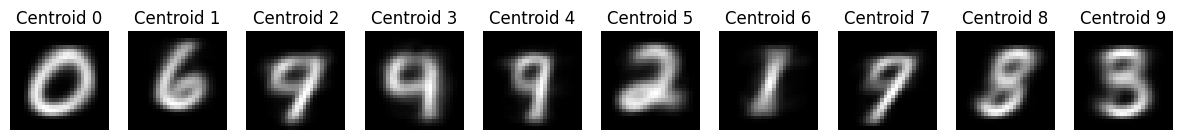

In [ ]:
import matplotlib.pyplot as plt

def plot_centroids(centroids):
    fig, axs = plt.subplots(1, len(centroids), figsize=(15, 3))

    for i, centroid in enumerate(centroids):
        img = centroid.reshape((28, 28))
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Centroid {i}')

    plt.show()

# Assuming normalized_centroids is your array of centroids
plot_centroids(normalized_centroids)


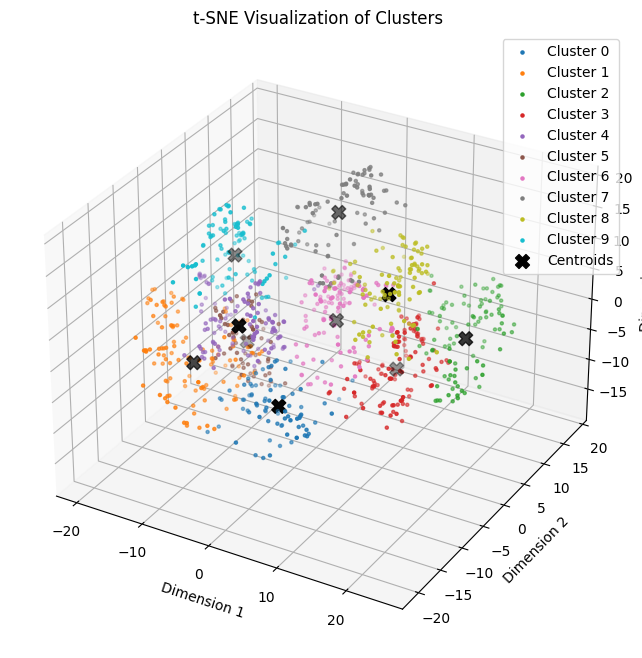

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot 3D scatter plot
def plot_3d_scatter(data, labels, centroids):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for data points
    for i in range(len(np.unique(labels))):
        cluster_points = data[labels == i]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {i}', s=5)

    # Scatter plot for centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=100, c='black', label='Centroids')

    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title('t-SNE Visualization of Clusters')
    ax.legend()
    plt.show()

# Function to apply t-SNE for dimensionality reduction to 3D
def apply_tsne(data, n_components=3):
    tsne = TSNE(n_components=n_components, random_state=42)
    reduced_data = tsne.fit_transform(data)
    return reduced_data

# Reduce the dimensionality of the data to 3D using t-SNE
reduced_data = apply_tsne(subset_digits)

# Run K-means on the reduced data
centroids, cluster_affiliation = kmeans(reduced_data, no_of_clusters)

# Plot the 3D scatter plot
plot_3d_scatter(reduced_data[:1000], cluster_affiliation[:1000], centroids)
